# LSTM Camels-ESP

In [1]:
%%capture
! pip install neuralhydrology

In [2]:
import pickle
import pandas as pd
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
import torch

from neuralhydrology.utils.config import Config
from neuralhydrology.evaluation import metrics
from neuralhydrology.nh_run import start_run, eval_run

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd /content/drive/MyDrive/TFM/notebook/models/
from model_utils import *
%cd ./EFAS5/

/content/drive/MyDrive/TFM/notebook/models
/content/drive/MyDrive/TFM/notebook/models/EFAS5


### Configuración

In [9]:
# cargar archivo de configuración
config_file = Path('config_test2.yml')
cfg = Config(config_file)

target = cfg.target_variables[0]

print(cfg.experiment_name)
print('epochs:', cfg.epochs, sep='\t\t')
print('hidden size:', cfg.hidden_size, sep='\t')
print('batch size:', cfg.batch_size, sep='\t')
print('dropout:', cfg.output_dropout, sep='\t')
print('clip gradients:', cfg.clip_gradient_norm, sep='\t')

EFAS_test2
epochs:		10
hidden size:	64
batch size:	256
dropout:	0.4
clip gradients:	1


### Entrenamiento

In [10]:
# by default we assume that you have at least one CUDA-capable NVIDIA GPU
if torch.cuda.is_available():
    start_run(config_file=config_file)

# fall back to CPU-only mode
else:
    start_run(config_file=config_file, gpu=-1)

# Validation: 100%|██████████| 100/100 [00:14<00:00,  7.03it/s]


### Simulación

In [11]:
run_dir = Path(f'runs/{cfg.experiment_name}_1609_185017')

In [12]:
# periodo de entrenamiento
for epoch in np.arange(1, cfg.epochs + 1):
    eval_run(run_dir=run_dir, period='train', epoch=epoch, gpu=0)
# eval_run(run_dir=run_dir, period='train', epoch=cfg.epochs, gpu=0)

# Evaluation: 100%|██████████| 163/163 [01:16<00:00,  2.13it/s]


In [13]:
# periodo de validación
#eval_run(run_dir=run_dir, period='validation', gpu=0)

In [14]:
# periodo de evaluación
for epoch in np.arange(1, cfg.epochs + 1):
    eval_run(run_dir=run_dir, period='test', epoch=epoch, gpu=0)
# eval_run(run_dir=run_dir, period='test', epoch=cfg.epochs, gpu=0)

# Evaluation: 100%|██████████| 53/53 [00:30<00:00,  1.73it/s]


## Resultados

In [15]:
# cargar los resultados para todas las épocas
results = {}
metrics = {period: pd.DataFrame(columns=range(1, cfg.epochs + 1)) for period in ['train', 'validation', 'test']}
for period, df in metrics.items():
    for epoch in df.columns:
        try:
            results_, df[epoch] = get_results(run_dir, period, epoch=epoch)
        except:
            continue

In [16]:
# definir la mejor época
best_epoch = {}
for period, df in metrics.items():
    epoch = df.median().idxmax()
    best_epoch[period] = epoch
    print('epoch {0:>2}:\tKGEtrain = {1:.3f}   KGEval = {2:.3f}   KGEtest = {3:.3f}'.format(epoch,
                                                                                         metrics['train'][epoch].median(),
                                                                                         metrics['validation'][epoch].median(),
                                                                                         metrics['test'][epoch].median()))
# extraer KGE de la mejor época
epoch = best_epoch['validation']

epoch  5:	KGEtrain = 0.772   KGEval = 0.770   KGEtest = 0.490
epoch  5:	KGEtrain = 0.772   KGEval = 0.770   KGEtest = 0.490
epoch  3:	KGEtrain = 0.715   KGEval = 0.683   KGEtest = 0.549


In [18]:
# epoch = 10

results = {}
metrics = pd.DataFrame()
for period in ['train', 'validation', 'test']:
    # importar resultados
    results_period, metrics_period = get_results(run_dir, period, epoch=epoch)
    metrics_period.columns = [period]
    results[period] = results_period
    metrics = pd.concat((metrics, metrics_period), axis=1)

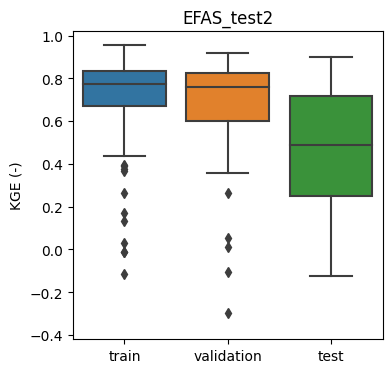

In [19]:
# diagramas de caja del rendimiento (KGE)
fig, ax = plt.subplots(figsize=(4, 4))
sns.boxplot(metrics, ax=ax)
ax.set(title=cfg.experiment_name, ylabel=f'{cfg.metrics[0]} (-)', ylim=(-.42, 1.02));

plt.savefig(run_dir / f'{cfg.metrics[0]}.jpg', dpi=300, bbox_inches='tight')

In [21]:
for period, dct in results.items():
    path = run_dir / 'hidrogramas' / period
    if path.exists() is False:
        path.mkdir(parents=True)
    plot_results(dct, period, target, save=path)

In [ ]:
# exportar rendimiento
metrics.to_csv(str(run_dir / f'{cfg.metrics[0]}.csv'), float_format='%.3f')